## Using this notebook

This notebook prepares the core spatial datasets used throughout the project, including the Ramona boundary, fire perimeters, buffers, and protected open space polygons. These layers will be reused in the shrubland and NDVI analyses.

### Step 0: Libraries
- Import required libraries.
### Step 1: Load Ramona Census Designated Places (CDP) boundary from CA CDP shapefile
- Sort the Ramona boundary from the CDP 2025 shapefile.
### Step 2: Load and extract Cedar (2003) and Witch (2007) fire perimeters
- Sort the two fire boundaries from the historical fire perimeters shapefile. We will need to sort both by YEAR and NAMELSAD.
### Step 3: Plot Ramona with the two fire perimeters
- Overlay our Ramona boundary with the two fire boundaries in a single figure.
### Step 4: (Optional side-quest) Creating a buffer around Ramona to clip CDP green space data to
- Create a Ramona buffer (10,000 meters) and clip selected greenspaces
### Remember: Save the clipped imagery after steps 1-3 in the plotted cells
- Save the Ramona CA, Cedar (2003) and Witch (2007) perimeters and export figures
- We won't save the optional side-quest image

### WARNING 
- This code was run locally. If reproducing this project, follow the directions below for downloading the required CA fire perimeter data and Ramona CDP data for this portion of the project. 
- Pay attention to your directories as well. Either delete the directories in code cell 2 or replace them with your own directory format.

In [1]:
# Step 0: Libraries
import os
from pathlib import Path
import geopandas as gpd
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import matplotlib.pyplot as plt
import zipfile

In [22]:
# Step 0.1: Add parameters

plt.rcParams['figure.figsize'] = (8, 8)

# Current notebook directory, e.g. .../ramona-fire-recovery/notebooks/02_fire_perimeters
NOTEBOOK_DIR = Path().resolve()

# Project root is two levels up: 02_fire_perimeters -> notebooks -> ramona-fire-recovery
PROJECT_ROOT = NOTEBOOK_DIR.parents[1]

DATA_DIR = PROJECT_ROOT / 'data'
BOUNDARY_DIR = DATA_DIR / 'boundaries'
IMAGERY_DIR = DATA_DIR / 'raw' / 'imagery'
FIG_DIR = Path(r"C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\figures\perimeters")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Project to California Albers
target_crs = 'EPSG:3310'

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR, "exists?", DATA_DIR.exists())
print("BOUNDARY_DIR:", BOUNDARY_DIR, "exists?", BOUNDARY_DIR.exists())
print("FIG_DIR:", FIG_DIR, "exists?", FIG_DIR.exists())

# Project to California Albers
target_crs = 'EPSG:3310'

PROJECT_ROOT, DATA_DIR

NOTEBOOK_DIR: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\notebooks\02_fire_perimeters
PROJECT_ROOT: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery
DATA_DIR: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data exists? True
BOUNDARY_DIR: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\boundaries exists? True
FIG_DIR: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\figures\perimeters exists? True


(WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery'),
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data'))

### Step 1: Load Ramona CDP boundary from CA CDP shapefile
In this step, we load California Census Designated Place (CDP) data and extract the polygon for Ramona, CA. This boundary serves as the geographic anchor for all subsequent analyses, including buffering, clipping fire perimeters, and intersecting vegetation data.

In [3]:
# Step 1: Load Ramona CDP boundary from CA CDP shapefile

# Path to the statewide CDP ZIP shapefile
cdp_zip = BOUNDARY_DIR / "California_Census_Designated_Places_(CDPs).zip"


cdp_zip = BOUNDARY_DIR / "California_Census_Designated_Places_(CDPs).zip"
print("cdp_zip:", cdp_zip)
print("cdp_zip exists?", cdp_zip.exists())  # should be True

cdp_gdf = gpd.read_file(cdp_zip)

# Looking at the column headings will help us identify where Ramona CDP is. 
# In the table below we can see we will need to filter by 'NAMESLAD'
cdp_gdf.head()

cdp_zip: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\boundaries\California_Census_Designated_Places_(CDPs).zip
cdp_zip exists? True


,PLACENS,GEOID,GEOIDFQ,NAMELSAD,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GlobalID,geometry
0,02582926,0600135,1600000US0600135,Acalanes Ridge CDP,U1,S,1193569.0,0.0,+37.9047250,-122.0785674,1d2479d9-6bf9-48bd-a01b-e99b830d63a1,"MULTIPOLYGON (((-183171.923 -11022.94, -183169..."
1,02629758,0600156,1600000US0600156,Acampo CDP,U1,S,2428474.0,0.0,+38.1735286,-121.2798915,0271a90c-05b1-4b9e-8064-a0229bfc9258,"POLYGON ((-112818.505 18883.406, -112079.991 1..."
2,02407697,0600212,1600000US0600212,Acton CDP,U1,S,101679451.0,60418.0,+34.4960703,-118.1838970,3c1128e0-0038-4209-af12-514a10751293,"POLYGON ((159739.983 -389681.743, 159918.46 -3..."
3,02582928,0600450,1600000US0600450,Agua Dulce CDP,U1,S,59181047.0,14646.0,+34.5016784,-118.3206796,2af5f189-989d-4432-9491-97457a519e95,"POLYGON ((148865.702 -393026.019, 148866.07 -3..."
4,02583084,0600535,1600000US0600535,Airport CDP,U2,S,451729.0,0.0,+37.6338833,-120.9720056,8da67b1e-d92b-43c7-89e3-c82dab78031b,"MULTIPOLYGON (((-85289.121 -41976.591, -85288...."


In [4]:
#### CONT ####
# Step 1: Load Ramona CDP boundary from CA CDP shapefile

# Filter for Ramona CDP using the NAMELSAD column
# We will use .copy() to ensure that our original dataframe cdp_gdf remains untouched and we can essentially 'view' Ramona instead
ramona_cdp = cdp_gdf[cdp_gdf["NAMELSAD"] == "Ramona CDP"].copy()

# Give us a count value of what we have filtered, it should be 1 as 'Ramona CDP' is unique in the shapefile
print("Number of features found:", len(ramona_cdp))

# Call the ramona_cdp dataframe copy of cdp_gdf to ensure we only have Ramona CDP left
ramona_cdp

Number of features found: 1


,PLACENS,GEOID,GEOIDFQ,NAMELSAD,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GlobalID,geometry
620,02409128,0659346,1600000US0659346,Ramona CDP,U1,S,99548575.0,49343.0,+33.0458112,-116.8775465,d02d9d44-3a58-4c89-8eae-34869d56b9f0,"POLYGON ((284494.265 -549275.975, 284493.414 -..."


In [5]:
#### CONT ####
# Step 1: Load Ramona CDP boundary from CA CDP shapefile

# We set our target crs earlier, so now we are just going to reproject to that here
ramona_cdp = ramona_cdp.to_crs(target_crs)

# Double check that the reprojection worked, the output should say EPSG:3310
print("Reprojected CRS:", ramona_cdp.crs)

Reprojected CRS: EPSG:3310


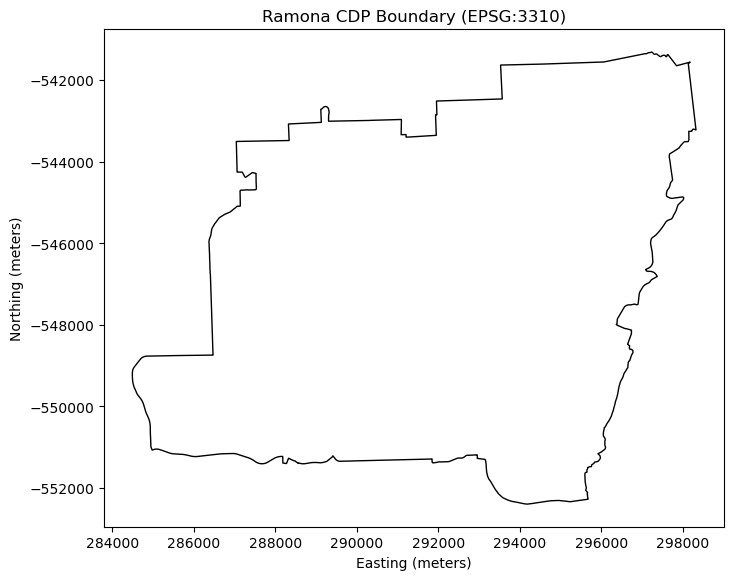

In [23]:
#### CONT ####
# Step 1: Load Ramona CDP boundary from CA CDP shapefile

fig, ax = plt.subplots(figsize=(8, 8))

# Now we can display the clipped boundary we created from our copied dataframe
# Using ';' at the end of the ax.set_title ensures we just get the figure and we truncate the value of the last expression

ramona_cdp.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1
)

ax.set_title("Ramona CDP Boundary (EPSG:3310)")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")

fig.savefig(FIG_DIR / "ramona_CDP_boundary.png",
            dpi=300,
            bbox_inches="tight")

## Accessing NDVI data
Due to the extent of this project (Ramona, CA + 2 fire boundaries) it is easier to request MODIS NDVI data from NASA EarthData. MODIS is a multispectral instrument that measures Red and NIR data (and so can be used for NDVI). 

Using the AppEEARS portal I have manually requested NDVI data from 01-01-2000 to 12-31-2020. You can also use an API to pull this data within your own codebook but I will not cover that here. 

To request your own extent area, you can do the following: 
1. Make sure you have a Earthdata account 
2. Go to the AppEEARS webpage: https://appeears.earthdatacloud.nasa.gov/
3. On the webpage go to the extract tab, and select 'area'
4. You can now either use an existing file to clip the extent of the area region you want or draw your own ploygon
5. In either case we want the data as a geoTIFF
6. Keep in mind that this request can take minutes, to hours, to longer depending on the status of the AppEEARS website

### Step 2: Load and extract Cedar and Witch fire perimeters
The CAL FIRE historic fire perimeter dataset includes thousands of fire footprints.  
Here we filter the dataset to extract only the perimeters for:
- **Cedar Fire (2003)**
- **Witch Creek Fire (2007)**  

We verify selection accuracy using the `ALARM_DATE` field, fire names, and perimeter shapes.


In [7]:
# Step 2: Load and extract Cedar (2003) and Witch (2007) fire perimeters

# So just like with the Ramona, CA shapefile, we have a 'California_Historic_Fire_Perimeters.zip' we can use for each fire perimeter
# We can reuse the code from when we made the Ramona, CA boundary.

# Path to the statewide historic fire perimeters ZIP shapefile
fire_perims_zip = BOUNDARY_DIR / 'California_Historic_Fire_Perimeters.zip'

# Read directly from the zipped shapefile
fires_gdf = gpd.read_file(f"zip://{fire_perims_zip}")

# Looking at the column headings will help us identify where the Cedar and Witch fires are.
### IMPORTANT ###
# Fire names are often reused over time, so we will need to specify both the name and year of fire we want sorted (most likely)
# We can check by calling the rows and columns of our dataframe

fires_gdf.head(5)

c:\Users\kayle\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: /vsizip/C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\boundaries\California_Historic_Fire_Perimeters.zip/California_Fire_Perimeters_(1950+).shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,1,23448.900,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-13193558.265 4032826.468, -13..."
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,1,14056.300,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-13146936.686 4051222.067, -13..."
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,1,10396.800,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-13197885.239 4107084.744, -13..."
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,1,998.738,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-13211054.577 4051508.758, -13211051..."
4,2025,CA,CDF,LDF,HURST,00003294,2025-01-07,2025-01-09,14,7,1,831.385,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-13187991.688 4073306.403, -13187979..."


In [8]:
#### CONT ####
# Step 2: Load and extract Cedar (2003) and Witch (2007) fire perimeters

# Filter for Cedar and Witch using the FIRE_NAME and YEAR columns
# We will use .copy() to ensure that our original dataframe fires_gdf remains untouched and we can essentially 'view' these fires instead

# For the cedar 2003 fire, there are actually two in 2003, one named CEDAR and one named CEDAR 3, so for the cedar 2003 sorting we need to:
# use == for CEDAR so that it only pulls that exact match. For the witch 2007 fire, because there is no other witch fire we can
# just set a general 'contains' parameter instead.

cedar_2003 = fires_gdf[
    (fires_gdf["FIRE_NAME"].str.upper() == "CEDAR") &
    (fires_gdf["YEAR_"] == 2003)
].copy()


witch_2007 = fires_gdf[
    (fires_gdf["FIRE_NAME"].str.contains("WITCH", case=False, na=False)) &
    (fires_gdf["YEAR_"] == 2007)
].copy()

# Give us a count value of what we have filtered, it should be 2
print(len(cedar_2003), "Cedar 2003 feature(s) found")
print(len(witch_2007), "Witch 2007 feature(s) found")

# Call the cedar_2003 and witch_2007 dataframe copies of fires_gdf to ensure we only have Witch and Cedar left
cedar_2003


1 Cedar 2003 feature(s) found
1 Witch 2007 feature(s) found


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
7396,2003,CA,USF,CNF,CEDAR,00000000,2003-10-25,2003-11-05,2,8,1,270686.0,None,None,None,00000087,None,2000-2009,"MULTIPOLYGON (((-13004972.924 3871624.82, -130..."


In [9]:
####CONT####
# Call the cedar_2003 and witch_2007 dataframe copies of fires_gdf to ensure we only have Witch and Cedar left
witch_2007

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
6155,2007,CA,CDF,MVU,WITCH,00000082,2007-10-21,2007-10-31,9,7,1,162070.0,None,None,None,00000082,None,2000-2009,"POLYGON ((-13004655.228 3924646.404, -13004650..."


## How else can we know these are the correct fires we are sorting?

We can also verify that we’ve selected the correct Cedar and Witch Fire perimeters by checking their start dates.

1. In this historic fire perimeters dataset, the start date of each fire is stored in the `ALARM_DATE` column.
2. For the **Cedar Fire (2003)**, the start date (`ALARM_DATE`) was **October 25, 2003**.
3. For the **Witch Fire (2007)**, the start date (`ALARM_DATE`) was **October 21, 2007**.
4. The containment date, stored in the `CONT_DATE` column, does **not** mean the fire was fully extinguished—only that spread was contained.
   - This is important because both fires continued burning beyond their containment dates.
   - For example, the Cedar Fire burned from **10/25/2003 to 12/5/2003**.
   - The Witch Fire burned from **10/21/2007 to 11/13/2007**.
5. In both cases, my hometown was displaced for over a month during each event, which is part of why I’m focusing on these fires in this analysis.


In [10]:
#### CONT ####
# Step 2: Load and extract Cedar (2003) and Witch (2007) fire perimeters

# We set our target crs earlier, so now we are just going to reproject to that here so all our boundaries use the same projection
cedar_2003 = cedar_2003.to_crs(target_crs)
witch_2007 = witch_2007.to_crs(target_crs)

# Double check that the reprojection worked, the output should say EPSG:3310
print("Cedar 2003 CRS:", cedar_2003.crs)
print("Witch 2007 CRS:", witch_2007.crs)

Cedar 2003 CRS: EPSG:3310
Witch 2007 CRS: EPSG:3310


### Step 3: Plot Ramona with the two fire perimeters
Here we will plot our three boundaries now that we have the witch and cedar fires pulled out from the CAL FIRE dataset. Since we are overlaying these, we will give these different colors (edgecolor). 

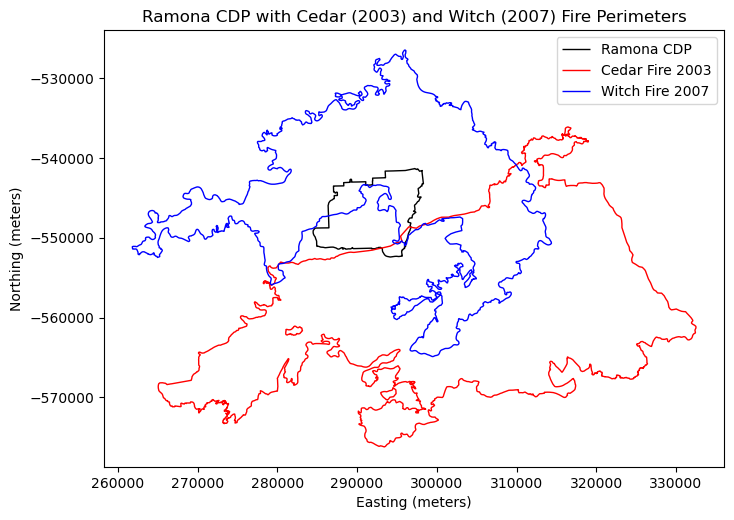

In [24]:
# Step 3: Plot Ramona with the two fire perimeters

# Now we will create and display our boundaries combined with the Ramona, CA boundary we made earlier

fig, ax = plt.subplots(figsize=(8, 8))

# Plot Ramona boundary
ramona_cdp.boundary.plot(ax=ax, edgecolor="black", linewidth=1, label="Ramona CDP")

# Plot Cedar Fire (2003)
cedar_2003.boundary.plot(ax=ax, edgecolor="red", linewidth=1, label="Cedar Fire 2003")

# Plot Witch Fire (2007)
witch_2007.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, label="Witch Fire 2007")

ax.set_title("Ramona CDP with Cedar (2003) and Witch (2007) Fire Perimeters")
ax.legend()
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
fig.savefig(FIG_DIR / "ramona_CDP_with_Cedar_Witch_boundaries.png",
            dpi=300,
            bbox_inches="tight")

## The ring of fire: Ramona, CA (2003–2007)

As Ramonians, we have a long relationship with fire. The map above shows how the Cedar Fire (2003) and the Witch Creek Fire (2007) effectively enclosed Ramona from the south and north. These fires are not isolated events—they emerge from the ecological and geographic reality of Ramona’s position within the San Diego backcountry.

Ramona is surrounded by open space preserves and fire-adapted landscapes, including coastal sage scrub, chaparral, oak woodlands, and the Cleveland National Forest. This region experiences some of the highest fire recurrence intervals in the state, especially during Santa Ana wind events that push large wildfires rapidly westward toward populated areas. While I say that Ramona experiences a 'ring of fire' it is also not wrong to say it lives within a 'ring of green.' 

Before 2003, the most destructive fire in modern California history was the 1970 Laguna Fire. It burned much farther south, at a time when this part of San Diego County was far less populated. But in 2003, the Cedar Fire became the largest fire in state history at that time. Today, it still ranks in the top 20 for both size and destruction. Similarly, the Witch Creek Fire was among the largest fires when it burned in 2007, even though it no longer appears in the top 20 today. Both left a lasting impact on Ramona and the surrounding communities.

What has always been troubling to many Ramonians is how San Diego County has often attempted to control the narrative of these disasters, despite Ramona being an unincorporated area that frequently receives limited direct support. During both fires, residents relied heavily on themselves and neighboring rural communities. After the Witch Creek Fire, San Diego Gas & Electric did attempt to recover wildfire costs from ratepayers through a proposed rate increase, but the California Public Utilities Commission (CPUC) denied this request. SDG&E proposed passing about $379 million in wildfire-related costs from the 2007 fire onto its customers through a rate hike, but the CPUC denied this request in 2017. Similarly, the last of the individual lawsuits against SDG&E was not resolved until 2014. 

These fires form what I call the “ring of fire” that continues to shape Ramona’s identity, memory, and vulnerability.


### Step 4: (Optional) Side quest

The below code cells help us create a list of open-space and protected areas around Ramona included in this analysis. These shapefiles are used to contextualize vegetation change and map regional conservation boundaries.


In [12]:
# Special side quest
# Lets investigate the 'green ring' of Ramona further using CPAD data. 

# This collection includes geospatial data on California lands which are protected by under ownership or easement. 
# These include the California Protected Areas Database (CPAD) and the California Conservation Easement Database (CCED).

cpad_zip = BOUNDARY_DIR / "cpad_2025a.zip"

cpad_super = gpd.read_file(f"zip://{cpad_zip}!CPAD_2025a_SuperUnits.shp")

In [13]:
# Inspect the dataset
cpad_super.head(5)

,ACCESS_TYP,PARK_NAME,PARK_URL,SUID_NMA,MNG_AG_ID,MNG_AGENCY,MNG_AG_LEV,MNG_AG_TYP,AGNCY_WEB,LAYER,ACRES,LABEL_NAME,YR_EST,GAP1_acres,GAP2_acres,GAP3_acres,GAP4_acres,GAP_tot_ac,geometry
0,Open Access,Deer Canyon Park,http://www.anaheim.net/comm_svc/parks/parkDeta...,129,1006,"Anaheim, City of",City,City Agency,https://www.anaheim.net/comm_svc/parks/,City,286.396931,Deer Canyon Park,0,0.0,0.00,0.0,286.0,286.00,"POLYGON ((207932.86 -458338.406, 207905.623 -4..."
1,Open Access,Arcata Community Forest,http://www.cityofarcata.org/departments/enviro...,295,1432,"Arcata, City of",City,City Agency,https://www.cityofarcata.org/rec,City,654.491867,Arcata Community Forest,0,0.0,0.00,653.0,0.0,653.00,"POLYGON ((-343521.833 324576.822, -343521.918 ..."
2,Open Access,Modini Mayacamas Preserves,http://egret.org/visit_modini_mayacamas,383,3005,Audubon Canyon Ranch,Non Profit,Non Profit - Conservation,https://www.egret.org,Non Governmental Organization,2863.749714,Modini Mayacamas Preserves,0,0.0,2859.00,0.0,0.0,2859.00,"MULTIPOLYGON (((-240507.377 79636.678, -240467..."
3,Open Access,Wright's Field,https://www.facebook.com/WrightsField,399,3007,Back Country Land Trust,Non Profit,Non Profit - Land Trust,https://www.bclt.org/,Non Governmental Organization,232.148088,Wright's Field,0,0.0,0.00,0.0,228.0,228.00,"MULTIPOLYGON (((303285.394 -572236.826, 303512..."
4,Open Access,Kern River Parkway Park,http://www.bakersfieldcity.us/recreation/Kern_...,425,1019,"Bakersfield, City of",City,City Agency,http://www.bakersfieldcity.us/recreation/,City,1115.695945,Kern River Parkway Park,0,0.0,0.04,0.0,1090.4,1090.44,"MULTIPOLYGON (((78899.227 -295825.489, 78895.0..."


In [14]:
# So we have way too many rows to inspect for the areas around Ramona. lets do a clip-buffer instead. 
# We are going to essentially "spatially filter" rather than sorting by any particular column in the shapefile.

# Reproject CPAD superunits to EPSG:3310
cpad_super_3310 = cpad_super.to_crs(target_crs)

cpad_super_3310.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Why create a 10 km Buffer Around Ramona?
To ensure complete coverage of nearby burned areas and vegetation patterns, we create a 10 km buffer around the Ramona CDP polygon. This buffer acts as a region of interest (ROI) for clipping fire perimeters, NDVI, and shrub cover data.


Text(-5.152777777777784, 0.5, 'Northing (meters)')

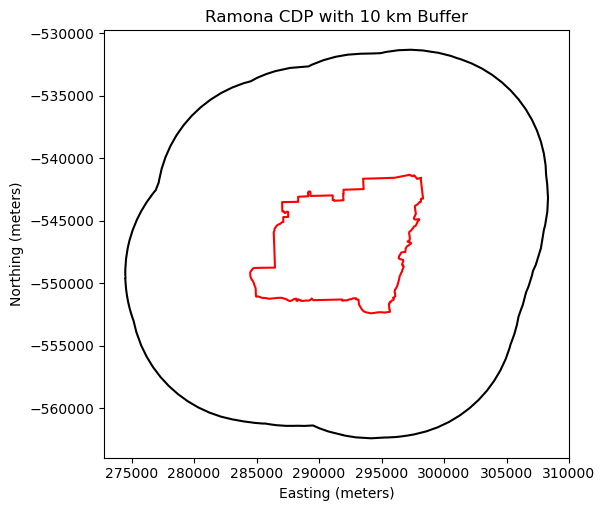

In [15]:
# Ensure Ramona is in the same CRS. We already had a reprojection variable for the Ramona boundary but lets keep these seperate. 
# So we will create another ramona var that has this same project (which means for our variables we have 2 with the same parameters).
ramona_3310 = ramona_cdp.to_crs(target_crs)

# Create a 20 km buffer around Ramona
ramona_buffer = ramona_3310.buffer(10000)  # 10,000 meters = 10 km

# Quick plot to check
ax = ramona_buffer.boundary.plot(edgecolor="black", figsize=(6, 6))
ramona_3310.boundary.plot(ax=ax, edgecolor="red")
ax.set_title("Ramona CDP with 10 km Buffer");
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")

In [16]:
# Filter CPAD superunits to only those that intersect the Ramona buffer
# Use union_all to dissolve the buffer geometry
ramona_buffer_union = ramona_buffer.union_all()

# Keep only CPAD features intersecting this buffer
cpad_near_ramona = cpad_super_3310[
    cpad_super_3310.intersects(ramona_buffer_union)
].copy()

len(cpad_near_ramona)

78

In [17]:
nearby_parks = (
    cpad_near_ramona["PARK_NAME"]
    .drop_duplicates()
    .sort_values()
)

for name in nearby_parks:
    print(name)

# View as scrollable element to see all 69 areas. We dropped duplicates so we went from 78 to 69 entries of green spaces.


Aubrey Park
BLM
Barnett Ranch Preserve
Blue Sky Ecological Reserve
Boden Canyon Ecological Reserve
Boulder Oaks Open Space Preserve
CWA Open Space
California State Lands Commission
Canada de San Vicente Ecological Reserve
City of Poway Open Space
City of San Diego Open Space
Cleveland Corridor Conservation Bank
Cleveland National Forest
Collier Park
Corral Mountain Open Space
Dos Picos Park
El Cajon Mountain Preserve
El Capitan Preserve
El Capitan Reservoir
Garden Road Neighborhood Park
Goodan Ranch Sycamore Canyon Preserve
Helix Water District Open Space
Hilleary Park
Holly Oaks Park
Iron Mountain Open Space
Iron Mountain Preserve
Kent Hill Open Space
Lake Poway Park
Lake Poway Recreation Area
Lake Ramona
Luelf Pond Preserve
Montecito Ranch
Mt. Gower Preserve
Mt. Woodson Gateway County Preserve
Oakoasis Preserve
Old Poway Park and Railroad
Pamo Valley
Pamo Watershed
Poway Creek Riparian Preserve
Ramona Community Park
Ramona Grasslands Preserve
Ramona Municipal Water District
Rattlesna

In [18]:
# Lets filter some of the main 'green spaces' around ramona

# List of key parks I picked
key_parks = [
    "Barnett Ranch Preserve",
    "Boden Canyon Ecological Reserve",
    "Canada de San Vicente Ecological Reserve",
    "Cleveland National Forest",
    "Iron Mountain Open Space",
    "Iron Mountain Preserve",
    "Mt. Gower Preserve",
    "Mt. Woodson Gateway County Preserve",
    "Ramona Grasslands Preserve",
    "Rock Haven Spring Open Space",
]

# Filter to only those parks (exact name matches)
key_parks_gdf = cpad_near_ramona[
    cpad_near_ramona["PARK_NAME"].isin(key_parks)
].copy()

print("Number of superunits for selected parks:", len(key_parks_gdf))
key_parks_gdf[["PARK_NAME"]].drop_duplicates()


Number of superunits for selected parks: 11


,PARK_NAME
424,Iron Mountain Open Space
579,Cleveland National Forest
7373,Rock Haven Spring Open Space
10122,Barnett Ranch Preserve
10842,Mt. Gower Preserve
11617,Ramona Grasslands Preserve
12091,Boden Canyon Ecological Reserve
14148,Canada de San Vicente Ecological Reserve
15568,Iron Mountain Preserve
15726,Mt. Woodson Gateway County Preserve


In [19]:
# Clip these parks even further before plotting

# Start from your selected parks in 3310
parks_3310 = key_parks_gdf.to_crs(target_crs)

# Clip parks to within the 5 km buffer around Ramona
parks_clipped = gpd.clip(parks_3310, ramona_buffer_union)

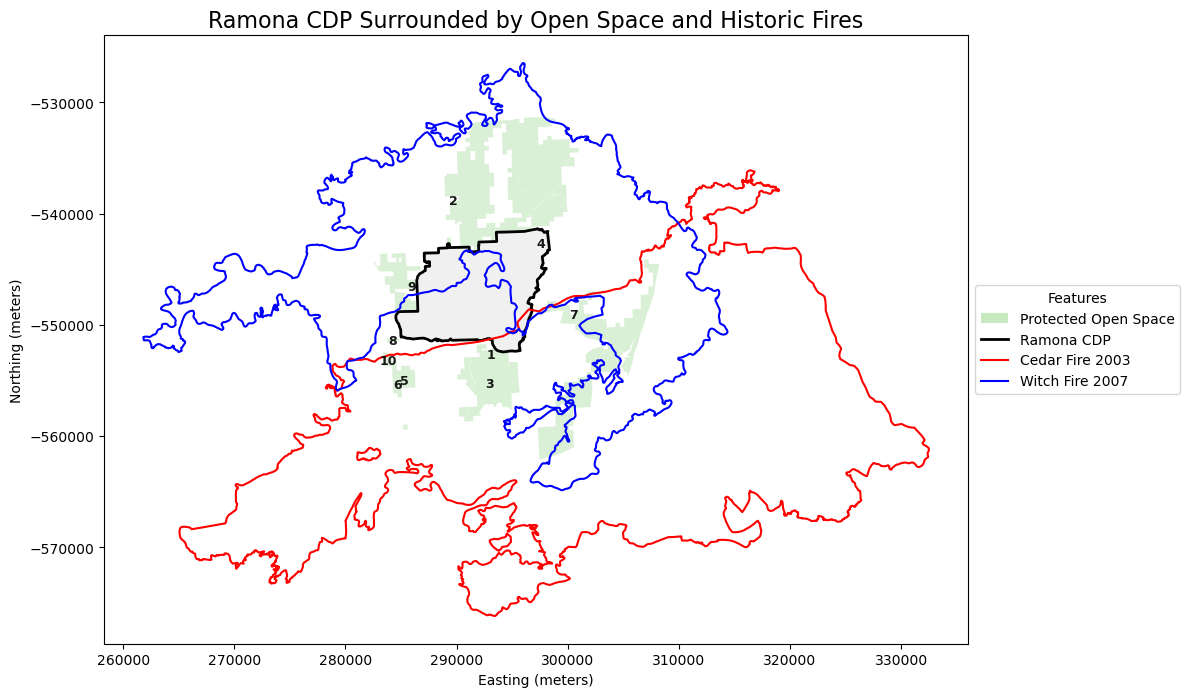

In [20]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Make sure everything else is still in the right reprojection

# Make sure everything is in the same CRS (defensive, but safe)
ramona_3310 = ramona_cdp.to_crs(target_crs)
cedar_3310 = cedar_2003.to_crs(target_crs)
witch_3310 = witch_2007.to_crs(target_crs)

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Protected open space (clipped)
parks_clipped.plot(
    ax=ax,
    color="#c7e9c0",
    alpha=0.65,
    edgecolor="none"
)

# 2. Ramona (subtle fill)
ramona_3310.plot(
    ax=ax,
    facecolor="#f0f0f0",
    edgecolor="black",
    linewidth=2
)

# 3. Fire perimeters
cedar_3310.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
witch_3310.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.5)

# ---- NUMBERED LABELS ----
# Dissolve by park name so we get one centroid per park
label_df = parks_clipped.dissolve(by="PARK_NAME", as_index=False)
label_df["ID"] = range(1, len(label_df) + 1)

for _, row in label_df.iterrows():
    cx, cy = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(
        cx, cy,
        str(row["ID"]),          # just the number
        fontsize=9,
        ha="center",
        va="center",
        color="black",
        weight="bold",
        alpha=0.9,
    )

# Legend for feature types only (not each park)
legend_elements = [
    mpatches.Patch(facecolor="#c7e9c0", edgecolor="none", label="Protected Open Space"),
    Line2D([0], [0], color="black", lw=2, label="Ramona CDP"),
    Line2D([0], [0], color="red", lw=1.5, label="Cedar Fire 2003"),
    Line2D([0], [0], color="blue", lw=1.5, label="Witch Fire 2007"),
]

ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Features"
)

ax.set_title("Ramona CDP Surrounded by Open Space and Historic Fires", fontsize=16)
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
ax.set_aspect("equal")
plt.tight_layout()


In [21]:
label_df[["ID", "PARK_NAME"]].sort_values("ID")

,ID,PARK_NAME
0,1,Barnett Ranch Preserve
1,2,Boden Canyon Ecological Reserve
2,3,Canada de San Vicente Ecological Reserve
3,4,Cleveland National Forest
4,5,Iron Mountain Open Space
5,6,Iron Mountain Preserve
6,7,Mt. Gower Preserve
7,8,Mt. Woodson Gateway County Preserve
8,9,Ramona Grasslands Preserve
9,10,Rock Haven Spring Open Space


**Protected Open Space Around Ramona**

1. Barnett Ranch Preserve  
2. Boden Canyon Ecological Reserve  
3. Canada de San Vicente Ecological Reserve  
4. Cleveland National Forest  
5. Iron Mountain Open Space  
6. Iron Mountain Preserve  
7. Mt. Gower Preserve  
8. Mt. Woodson Gateway County Preserve  
9. Ramona Grasslands Preserve  
10. Rock Haven Spring Open Space  

### Preparing codes for storing
We did a lot of work in this notebook, and you may not remember all the variables in use. We can use '%whos' to see all variables.

In [30]:
# Look at all variables
%whos

Variable              Type            Data/Info
-----------------------------------------------
BOUNDARY_DIR          WindowsPath     C:\Users\kayle\Desktop\ea<...>-recovery\data\boundaries
DATA_DIR              WindowsPath     C:\Users\kayle\Desktop\ea<...>ramona-fire-recovery\data
IMAGERY_DIR           WindowsPath     C:\Users\kayle\Desktop\ea<...>recovery\data\raw\imagery
Line2D                type            <class 'matplotlib.lines.Line2D'>
NOTEBOOK_DIR          WindowsPath     C:\Users\kayle\Desktop\ea<...>ebooks\02_fire_perimeters
PROJECT_ROOT          WindowsPath     C:\Users\kayle\Desktop\ea<...>ject\ramona-fire-recovery
Path                  type            <class 'pathlib.Path'>
ax                    Axes            Axes(0.0909606,0.19583;0.720023x0.608339)
cdp_gdf               GeoDataFrame           PLACENS    GEOID  <...>n[1136 rows x 12 columns]
cdp_zip               WindowsPath     C:\Users\kayle\Desktop\ea<...>ignated_Places_(CDPs).zip
cedar_2003            GeoDataFram

### Storing variables for later notebooks
The `%store` command makes the cleaned annual temperature dataframe available to other notebooks in this project without needing to reload or reprocess the original data.
You should not store plots. 

In [25]:
# Store variables 
%store PROJECT_ROOT  DATA_DIR  BOUNDARY_DIR  ramona_cdp cedar_2003  cedar_3310  witch_2007  witch_3310  fires_gdf ramona_3310  ramona_buffer  ramona_buffer_union target_crs

Stored 'PROJECT_ROOT' (WindowsPath)
Stored 'DATA_DIR' (WindowsPath)
Stored 'BOUNDARY_DIR' (WindowsPath)
Stored 'ramona_cdp' (GeoDataFrame)
Stored 'cedar_2003' (GeoDataFrame)
Stored 'cedar_3310' (GeoDataFrame)
Stored 'witch_2007' (GeoDataFrame)
Stored 'witch_3310' (GeoDataFrame)
Stored 'fires_gdf' (GeoDataFrame)
Stored 'ramona_3310' (GeoDataFrame)
Stored 'ramona_buffer' (GeoSeries)
Stored 'ramona_buffer_union' (Polygon)
Stored 'target_crs' (str)
